# 03 - Modeling

Build models to predict "Percent_Bleached".

**Approach:**
1. Load and engineer features based on EDA recommendations
2. Manual grid search with cross-validation
3. Test multiple models and hyperparameters
4. Save best model based on Test MAE

In [37]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import sys

from pipeline.weights import WeightingConfig

sys.path.append('..')
from pipeline import PipelineConfig, PipelineFactory
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


## Load Training Data

In [38]:
# Load training data
filepath_train = r"../data/cleaned_data_after_eda.csv"
df = pd.read_csv(filepath_train)

print(f"Training data shape: {df.shape}")
print(f"Target: Percent_Bleached")
print(f"Mean: {df['Percent_Bleached'].mean():.2f}, Std: {df['Percent_Bleached'].std():.2f}")
df.head()

Training data shape: (3663, 43)
Target: Percent_Bleached
Mean: 24.09, Std: 33.58


,Unnamed: 0,Sample_ID,Site_ID,ClimSST,Temperature_Kelvin,Temperature_Mean,Temperature_Minimum,Temperature_Maximum,Temperature_Kelvin_Standard_Deviation,Windspeed,...,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Depth_m,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Percent_Bleached,is_dup
0,0,10274495.0,12082.0,301.65,303.50,299.79,293.35,305.54,2.52,2.0,...,0.74,6.05,0.22,8.3,8311.0,exposed,0.0586,56.583448,4.76,False
1,1,10274496.0,12083.0,299.31,300.84,299.75,293.68,305.44,2.54,6.0,...,0.93,10.39,0.27,14.9,10747.0,exposed,0.0543,52.842523,21.88,False
2,2,10274497.0,12084.0,300.56,302.65,299.81,293.35,305.47,2.50,5.0,...,0.83,7.18,0.23,10.7,9396.0,exposed,0.0571,56.583448,19.66,False
3,3,10274498.0,12085.0,299.75,302.43,299.81,293.35,305.47,2.50,7.0,...,0.83,7.18,0.23,7.6,9408.0,exposed,0.0571,56.583448,28.03,False
4,4,10274500.0,12086.0,299.35,302.23,299.81,293.35,305.47,2.50,4.0,...,0.83,7.18,0.23,9.7,9362.0,exposed,0.0571,56.583448,43.59,False


## Feature Engineering (EDA Recommendations)

Implementing all recommendations from EDA:
1. **Depth Categories** (Shallow/Medium/Deep)
2. **Offshore Indicator** (binary)
3. **Interaction Terms** (Temp × Depth, SSTA_DHW × Frequency, etc.)
4. **Site-Level Features** (historical site means)
5. **Drop multicollinear features** (TSA_DHW, SSTA_Mean)
6. **Handle categorical** (Exposure one-hot encoding)

In [39]:
# 1. Drop columns that shouldn't be features
columns_to_drop = ['Sample_ID', 'SSTA_Mean', 'TSA_DHW']
if 'Unnamed: 0' in df.columns:
    columns_to_drop.append('Unnamed: 0')
if 'is_dup' in df.columns:
    columns_to_drop.append('is_dup')

# Keep Site_ID temporarily for site-level features
TARGET = 'Percent_Bleached'
X_temp = df.drop(columns=[col for col in columns_to_drop if col != 'Site_ID'] + [TARGET])
y = df[TARGET]

print(f"Original features: {X_temp.shape[1]}")

# 2. Depth Categories (from EDA: shallow 0-10m, medium 10-20m, deep >20m)
X_temp['Depth_Shallow'] = (X_temp['Depth_m'] <= 10).astype(int)
X_temp['Depth_Medium'] = ((X_temp['Depth_m'] > 10) & (X_temp['Depth_m'] <= 20)).astype(int)
X_temp['Depth_Deep'] = (X_temp['Depth_m'] > 20).astype(int)

# 3. Offshore indicator
offshore_threshold = X_temp['Distance_to_Shore'].median()
X_temp['Is_Offshore'] = (X_temp['Distance_to_Shore'] > offshore_threshold).astype(int)

# 4. Interaction terms
X_temp['Temp_x_Depth'] = X_temp['Temperature_Mean'] * X_temp['Depth_m']
X_temp['SSTA_DHW_x_Frequency'] = X_temp['SSTA_DHW'] * X_temp['SSTA_Frequency']
X_temp['TSA_Frequency_x_Depth'] = X_temp['TSA_Frequency'] * X_temp['Depth_m']

# 5. Site-level aggregated features (historical site means)
site_agg = df.groupby('Site_ID').agg({
    'Temperature_Mean': 'mean',
    'SSTA_DHW': 'mean',
    'TSA_Frequency': 'mean',
    'Depth_m': 'mean',
    'Percent_Bleached': 'mean'
}).rename(columns={
    'Temperature_Mean': 'Site_Temp_Mean',
    'SSTA_DHW': 'Site_SSTA_DHW_Mean',
    'TSA_Frequency': 'Site_TSA_Freq_Mean',
    'Depth_m': 'Site_Depth_Mean',
    'Percent_Bleached': 'Site_Historical_Bleaching'
})

# Merge site features
X_temp = X_temp.merge(site_agg, left_on='Site_ID', right_index=True, how='left')

# Now drop Site_ID
X_temp = X_temp.drop(columns=['Site_ID'])

print(f"\nEngineered features: {X_temp.shape[1]}")
print(f"Added: {X_temp.shape[1] - 37} new features")
print(f"\nNew features:")
new_features = ['Depth_Shallow', 'Depth_Medium', 'Depth_Deep', 'Is_Offshore',
                'Temp_x_Depth', 'SSTA_DHW_x_Frequency', 'TSA_Frequency_x_Depth',
                'Site_Temp_Mean', 'Site_SSTA_DHW_Mean', 'Site_TSA_Freq_Mean',
                'Site_Depth_Mean', 'Site_Historical_Bleaching']
for feat in new_features:
    print(f"  - {feat}")

Original features: 37

Engineered features: 48
Added: 11 new features

New features:
  - Depth_Shallow
  - Depth_Medium
  - Depth_Deep
  - Is_Offshore
  - Temp_x_Depth
  - SSTA_DHW_x_Frequency
  - TSA_Frequency_x_Depth
  - Site_Temp_Mean
  - Site_SSTA_DHW_Mean
  - Site_TSA_Freq_Mean
  - Site_Depth_Mean
  - Site_Historical_Bleaching


In [40]:
# Define column types for pipeline
numerical_cols = X_temp.select_dtypes(include='number').columns.tolist()
categorical_cols = ['Exposure'] if 'Exposure' in X_temp.columns else []

# Features that benefit from log transformation (from EDA)
log_cols = [col for col in ['Distance_to_Shore', 'SSTA_Frequency', 'TSA_Frequency', 
                             'Cyclone_Frequency', 'Turbidity'] 
            if col in numerical_cols]

print(f"Pipeline configuration:")
print(f"  Numerical: {len(numerical_cols)}")
print(f"  Categorical: {len(categorical_cols)}")
print(f"  Log-transformed: {len(log_cols)}")

# Final feature matrix
X = X_temp.copy()

Pipeline configuration:
  Numerical: 47
  Categorical: 1
  Log-transformed: 5


## Train-Test Split

In [41]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train-test split:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Test: {X_test.shape[0]} samples")
print(f"  Features: {X_train.shape[1]}")

Train-test split:
  Training: 2930 samples
  Test: 733 samples
  Features: 48


## Manual Grid Search with Cross-Validation

Testing multiple models and hyperparameters:
- **Models**: Linear Regression, Lasso, Decision Tree, Random Forest, HGBR, HGBR with log target
- **Feature Selection**: None, MI with 15/20/25 features
- **Validation**: 5-fold cross-validation
- **Metric**: Mean Absolute Error (MAE)

In [42]:
# Define grid search space
param_grid = {
    'model_name': ['linreg', 'lasso', 'dt_regressor', 'rf_regressor', 'hgbr', 'hgb_log'],
    'selector_kind': [None, 'mi'],
    'selector_k': [None, 15, 20, 25]
}

print("Grid Search Configuration:")
print(f"  Models: {param_grid['model_name']}")
print(f"  Feature Selection: {param_grid['selector_kind']}")
print(f"  Number of Features: {param_grid['selector_k']}")

# Calculate total combinations
total_trials = len(param_grid['model_name']) * len(param_grid['selector_kind']) * len(param_grid['selector_k'])
print(f"\nTotal trials: {total_trials}")

Grid Search Configuration:
  Models: ['linreg', 'lasso', 'dt_regressor', 'rf_regressor', 'hgbr', 'hgb_log']
  Feature Selection: [None, 'mi']
  Number of Features: [None, 15, 20, 25]

Total trials: 48


In [43]:
# Run manual grid search
from itertools import product

results = []
factory = PipelineFactory()

print("Starting grid search...\n")
print("="*80)

trial_num = 0
for model_name, selector_kind, selector_k in product(
    param_grid['model_name'],
    param_grid['selector_kind'],
    param_grid['selector_k']
):
    trial_num += 1
    
    # Skip invalid combinations (selector_k without selector_kind)
    if selector_kind is None and selector_k is not None:
        continue
    
    try:
        # Build pipeline
        config = PipelineConfig(
            numeric=numerical_cols,
            categorical=categorical_cols,
            log=log_cols,
            selector_kind=selector_kind,
            selector_k=selector_k,
            resampler="none",
            model_name=model_name
        )
        
        pipeline = factory.build(config)
        
        cv_scores = cross_val_score(
            pipeline, X_train, y_train,
            cv=5,
            scoring='neg_mean_absolute_error',
            n_jobs=-1
        )
        cv_mae = -cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Train on full training set and evaluate on test set
        pipeline.fit(X_train, y_train)
        
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Store results
        results.append({
            'trial': trial_num,
            'model_name': model_name,
            'selector_kind': selector_kind,
            'selector_k': selector_k,
            'cv_mae_mean': cv_mae,
            'cv_mae_std': cv_std,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'overfitting_ratio': train_mae / test_mae if test_mae > 0 else 999
        })
        
        print(f"[{trial_num:2d}/{total_trials}] {model_name:15s} | "
              f"Sel: {str(selector_kind):4s} K: {str(selector_k):4s} | "
              f"CV: {cv_mae:6.3f}±{cv_std:5.3f} | "
              f"Test: {test_mae:6.3f}")
        
    except Exception as e:
        print(f"[{trial_num:2d}/{total_trials}] {model_name:15s} | ERROR: {str(e)[:50]}")
        continue

print("="*80)
print(f"\nGrid search complete! Evaluated {len(results)} configurations.")

Starting grid search...

[ 1/48] linreg          | Sel: None K: None | CV:  7.711±0.356 | Test:  7.676
[ 5/48] linreg          | Sel: mi   K: None | CV:  7.711±0.356 | Test:  7.676
[ 6/48] linreg          | Sel: mi   K: 15   | CV:  7.140±0.236 | Test:  7.141
[ 7/48] linreg          | Sel: mi   K: 20   | CV:  7.199±0.248 | Test:  7.162
[ 8/48] linreg          | Sel: mi   K: 25   | CV:  7.242±0.247 | Test:  7.171
[ 9/48] lasso           | Sel: None K: None | CV:  7.640±0.396 | Test:  7.639
[13/48] lasso           | Sel: mi   K: None | CV:  7.640±0.396 | Test:  7.639
[14/48] lasso           | Sel: mi   K: 15   | CV:  7.092±0.276 | Test:  7.124
[15/48] lasso           | Sel: mi   K: 20   | CV:  7.137±0.293 | Test:  7.145
[16/48] lasso           | Sel: mi   K: 25   | CV:  7.186±0.282 | Test:  7.154
[17/48] dt_regressor    | Sel: None K: None | CV: 10.401±0.651 | Test: 10.456
[21/48] dt_regressor    | Sel: mi   K: None | CV: 10.401±0.651 | Test: 10.456
[22/48] dt_regressor    | Sel: mi   K: 

In [44]:
# Convert to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_mae').reset_index(drop=True)

print("\n" + "="*90)
print("TOP 10 MODELS (sorted by Test MAE)")
print("="*90)
display_cols = ['model_name', 'selector_kind', 'selector_k', 'cv_mae_mean', 
                'test_mae', 'train_mae', 'overfitting_ratio']
print(results_df[display_cols].head(10).to_string(index=False))
print("="*90)

# Best model
best = results_df.iloc[0]
print(f"\n🏆 BEST MODEL:")
print(f"  Model: {best['model_name']}")
print(f"  Feature Selection: {best['selector_kind']}")
print(f"  Number of Features: {best['selector_k']}")
print(f"  CV MAE: {best['cv_mae_mean']:.4f} ± {best['cv_mae_std']:.4f}")
print(f"  Test MAE: {best['test_mae']:.4f}")
print(f"  Train MAE: {best['train_mae']:.4f}")
print(f"  Overfitting Ratio: {best['overfitting_ratio']:.4f}")


TOP 10 MODELS (sorted by Test MAE)
model_name selector_kind  selector_k  cv_mae_mean  test_mae  train_mae  overfitting_ratio
     lasso            mi        15.0     7.092205  7.123715   6.965209           0.977749
    linreg            mi        15.0     7.139872  7.141241   6.976182           0.976886
     lasso            mi        20.0     7.137303  7.145368   6.994162           0.978839
     lasso            mi        25.0     7.186317  7.154394   7.003671           0.978933
    linreg            mi        20.0     7.199121  7.162126   7.014458           0.979382
    linreg            mi        25.0     7.241560  7.171211   7.026737           0.979854
     lasso          None         NaN     7.640158  7.638837   7.363192           0.963915
     lasso            mi         NaN     7.640158  7.638837   7.363192           0.963915
    linreg          None         NaN     7.710548  7.675758   7.383940           0.961982
    linreg            mi         NaN     7.710548  7.675758   7.

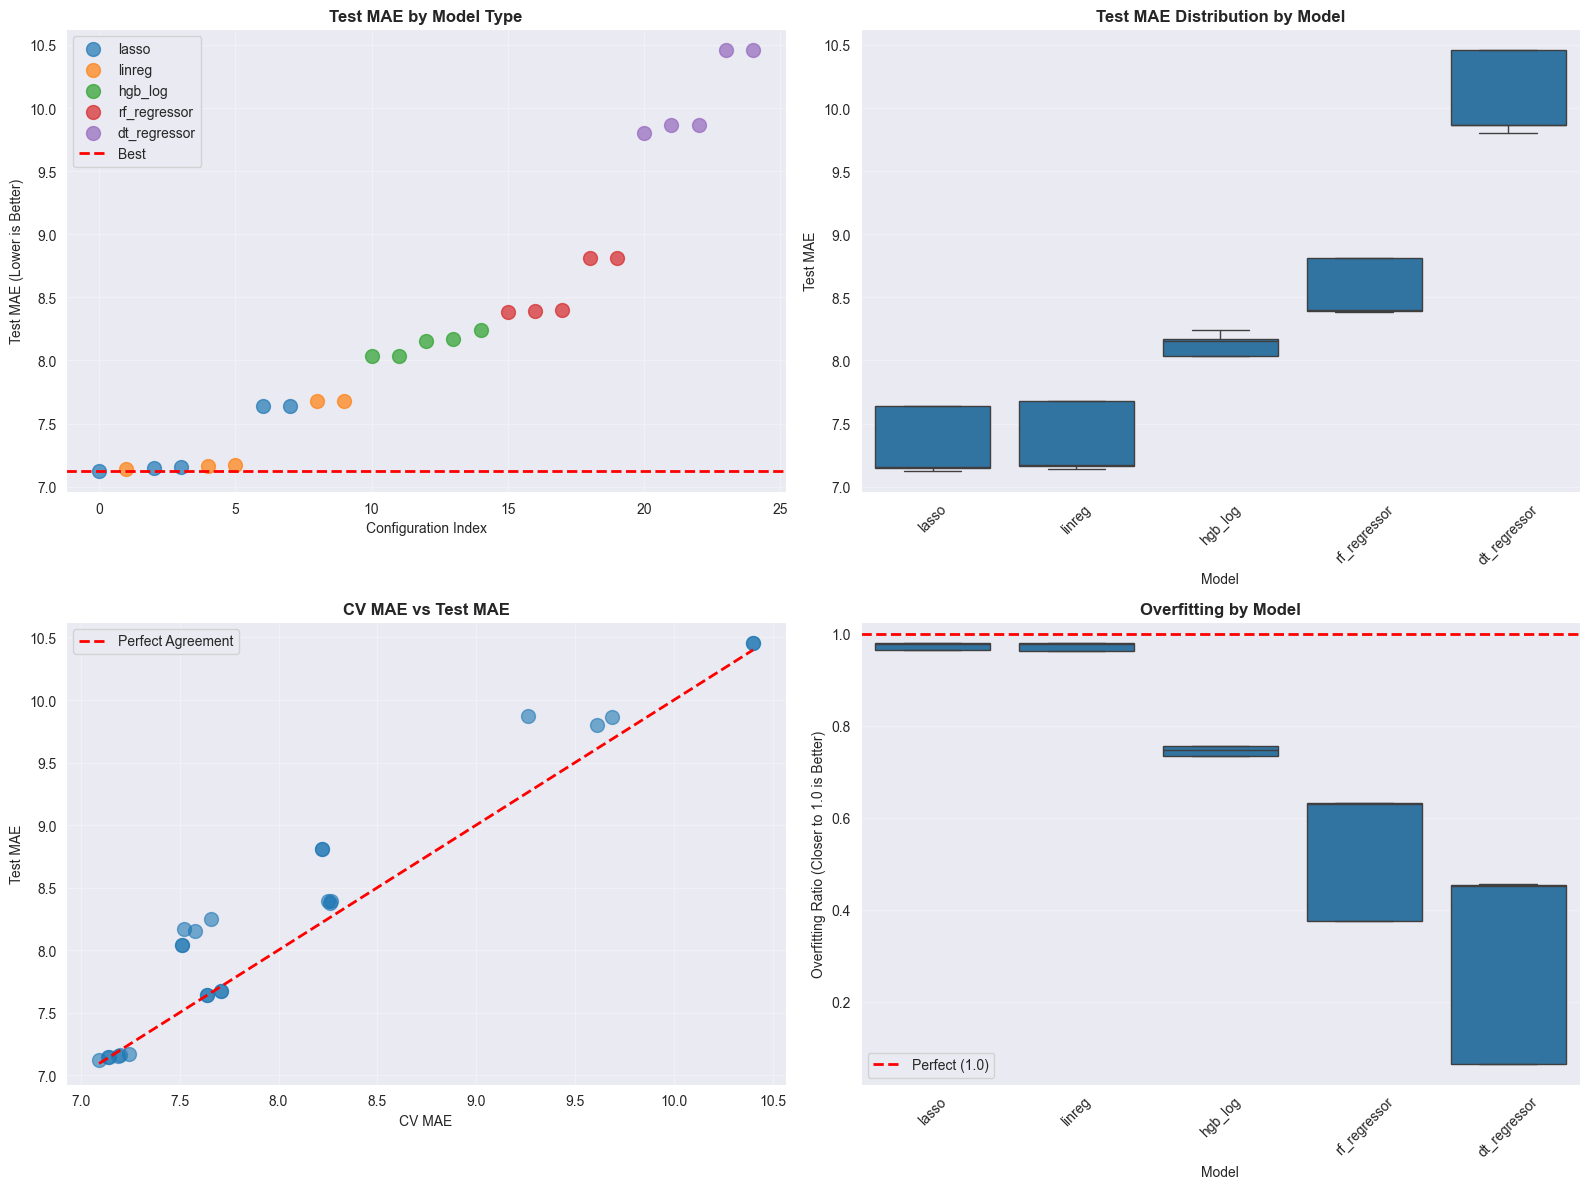

In [45]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Test MAE by model
ax1 = axes[0, 0]
for model in results_df['model_name'].unique():
    model_data = results_df[results_df['model_name'] == model]
    ax1.scatter(model_data.index, model_data['test_mae'], label=model, s=100, alpha=0.7)
ax1.axhline(best['test_mae'], color='red', linestyle='--', linewidth=2, label='Best')
ax1.set_xlabel('Configuration Index')
ax1.set_ylabel('Test MAE (Lower is Better)')
ax1.set_title('Test MAE by Model Type', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Test MAE distribution by model
ax2 = axes[0, 1]
sns.boxplot(data=results_df, x='model_name', y='test_mae', ax=ax2)
ax2.set_xlabel('Model')
ax2.set_ylabel('Test MAE')
ax2.set_title('Test MAE Distribution by Model', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: CV MAE vs Test MAE
ax3 = axes[1, 0]
ax3.scatter(results_df['cv_mae_mean'], results_df['test_mae'], alpha=0.6, s=100)
ax3.plot([results_df['cv_mae_mean'].min(), results_df['cv_mae_mean'].max()],
         [results_df['cv_mae_mean'].min(), results_df['cv_mae_mean'].max()],
         'r--', lw=2, label='Perfect Agreement')
ax3.set_xlabel('CV MAE')
ax3.set_ylabel('Test MAE')
ax3.set_title('CV MAE vs Test MAE', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Overfitting ratio by model
ax4 = axes[1, 1]
sns.boxplot(data=results_df, x='model_name', y='overfitting_ratio', ax=ax4)
ax4.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Perfect (1.0)')
ax4.set_xlabel('Model')
ax4.set_ylabel('Overfitting Ratio (Closer to 1.0 is Better)')
ax4.set_title('Overfitting by Model', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("../plots/modeling/10_grid_search_results.png", dpi=300, bbox_inches='tight')
plt.show()

## Retrain Best Model & Save

In [46]:
print("Retraining best model on full training data...\n")

selector_k_value = None if pd.isna(best['selector_k']) else int(best['selector_k'])

best_config = PipelineConfig(
    numeric=numerical_cols,
    categorical=categorical_cols,
    log=log_cols,
    selector_kind=best['selector_kind'],
    selector_k=selector_k_value,
    resampler="none",
    model_name=best['model_name']
)

factory = PipelineFactory()
final_pipeline = factory.build(best_config)
final_pipeline.fit(X_train, y_train)

y_train_final = final_pipeline.predict(X_train)
y_test_final = final_pipeline.predict(X_test)

final_train_mae = mean_absolute_error(y_train, y_train_final)
final_test_mae = mean_absolute_error(y_test, y_test_final)
final_train_r2 = r2_score(y_train, y_train_final)
final_test_r2 = r2_score(y_test, y_test_final)

print("="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"  Train MAE: {final_train_mae:.4f}")
print(f"  Test MAE:  {final_test_mae:.4f}")
print(f"  Train R²:  {final_train_r2:.4f}")
print(f"  Test R²:   {final_test_r2:.4f}")
print(f"  Overfitting Ratio: {final_train_mae/final_test_mae:.4f}")
print("="*60)

Retraining best model on full training data...

FINAL MODEL PERFORMANCE
  Train MAE: 6.9638
  Test MAE:  7.1303
  Train R²:  0.6897
  Test R²:   0.7288
  Overfitting Ratio: 0.9767


In [47]:
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

model_filename = f"best_model_{best['model_name']}.pkl"
model_path = os.path.join(models_dir, model_filename)

with open(model_path, 'wb') as f:
    pickle.dump(final_pipeline, f)

print(f"\nModel saved to: {model_path}")

metadata = {
    'model_name': best['model_name'],
    'selector_kind': str(best['selector_kind']),
    'selector_k': str(best['selector_k']),
    'cv_mae_mean': float(best['cv_mae_mean']),
    'cv_mae_std': float(best['cv_mae_std']),
    'test_mae': float(final_test_mae),
    'train_mae': float(final_train_mae),
    'test_r2': float(final_test_r2),
    'train_r2': float(final_train_r2),
    'overfitting_ratio': float(final_train_mae / final_test_mae),
    'training_samples': int(X_train.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'n_features_input': int(X_train.shape[1]),
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'log_cols': log_cols,
    'feature_engineering': {
        'depth_categories': True,
        'offshore_indicator': True,
        'interaction_terms': True,
        'site_level_features': True
    },
    'timestamp': datetime.now().isoformat()
}

metadata_path = os.path.join(models_dir, model_filename.replace('.pkl', '_metadata.json'))
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to: {metadata_path}")

results_path = os.path.join(models_dir, 'grid_search_results.csv')
results_df.to_csv(results_path, index=False)
print(f" Full results saved to: {results_path}")

print("\n" + "="*60)
print("MODEL TRAINING AND SAVING COMPLETE!")
print("="*60)


Model saved to: ../models/best_model_lasso.pkl
Metadata saved to: ../models/best_model_lasso_metadata.json
 Full results saved to: ../models/grid_search_results.csv

MODEL TRAINING AND SAVING COMPLETE!


## Test Saved Model

In [48]:
print("Loading saved model...\n")

with open(model_path, 'rb') as f:
    loaded_pipeline = pickle.load(f)

with open(metadata_path, 'r') as f:
    loaded_metadata = json.load(f)

print("Model loaded successfully!")
print(f"\nModel Details:")
print(f"  Type: {loaded_metadata['model_name']}")
print(f"  Test MAE: {loaded_metadata['test_mae']:.4f}")
print(f"  Training Date: {loaded_metadata['timestamp']}")
print(f"  Feature Engineering: {loaded_metadata['feature_engineering']}")

# Test on sample
print(f"\nTesting on first 5 test samples:")
sample_pred = loaded_pipeline.predict(X_test.iloc[:5])
sample_actual = y_test.iloc[:5].values

for i, (pred, actual) in enumerate(zip(sample_pred, sample_actual)):
    error = abs(pred - actual)
    print(f"  Sample {i+1}: Pred={pred:6.2f}, Actual={actual:6.2f}, Error={error:6.2f}")

Loading saved model...

Model loaded successfully!

Model Details:
  Type: lasso
  Test MAE: 7.1303
  Training Date: 2025-11-12T14:52:17.394399
  Feature Engineering: {'depth_categories': True, 'offshore_indicator': True, 'interaction_terms': True, 'site_level_features': True}

Testing on first 5 test samples:
  Sample 1: Pred=  1.51, Actual=  1.50, Error=  0.01
  Sample 2: Pred=  9.72, Actual=  9.92, Error=  0.20
  Sample 3: Pred=  2.06, Actual=  2.33, Error=  0.27
  Sample 4: Pred= -0.29, Actual=  0.00, Error=  0.29
  Sample 5: Pred= 50.24, Actual= 40.00, Error= 10.24


## Summary

### Feature Engineering Applied:
✅ Depth Categories (Shallow/Medium/Deep)  
✅ Offshore Indicator (binary)  
✅ Interaction Terms (Temp × Depth, SSTA_DHW × Frequency, TSA_Freq × Depth)  
✅ Site-Level Features (historical site means)  
✅ Multicollinearity Handling (dropped TSA_DHW, SSTA_Mean)  
✅ Log Transformations (Distance, Frequencies, Turbidity)  

### Grid Search Results:
- **Models Tested**: 6 (Linear, Lasso, DT, RF, HGBR, HGBR+Log)
- **Feature Selection**: None vs MI-based (15/20/25 features)
- **Validation**: 5-fold cross-validation
- **Metric**: Mean Absolute Error (MAE)

### Files Created:
- `../models/best_model_[name].pkl` - Trained pipeline
- `../models/best_model_[name]_metadata.json` - Configuration & metrics
- `../models/grid_search_results.csv` - All trial results
- `../plots/modeling/10_grid_search_results.png` - Visualizations

### Next Steps:
1. Use saved model for predictions on blinded dataset
2. Analyze feature importance from best model
3. Ensemble top models for improved performance
4. Generate predictions for submission